In [1]:
'''A script to run UQ for a pipe using PCN.

Parameters
----------

expan_coef: int
size of friction coefficient vector

uni_prior_down: float * expan_coef
lower bound for the uniform prior

uni_prior_up: float * expan_coef
upper bound for the uniform prior

initial_point_mcmc: float * expan_coef
initial point in the MCMC sampler

c_sound: float
sound speed

t_final: float
final time

x_l: float
left boundary of the domain

x_r: float
right boundary of the domain

dx: float
mesh size

boundary_eps: float
a number for computing pressure drop at both ends of the pipe

pipe_true: SemiLinSystem
an object that represents and contains attributes of the true pipe

pipe: SemiLinSystem 
an object that represents and contains attributes
of a pipe used during MCMC for sampling

'''

from UQuant.SemilinearSystem import SemiLinSystem
from bayesianinversion import MCMCBayesianInversion, PCNBayesianInversion
from numpy.random import normal

# build a pipe

## physical settings
c_sound = 1.0
t_final = 5.0
x_l, x_r = [0.0, 1.0]
dx = 0.005
boundary_eps = 0.05

## true friction coefficient
true_friction = [0.185938, -0.0519335, 0., 0., -0.0696583, 0.0336323, 0., 0., \
                 0.0348292, -0.0121076, 0., 0., -0.00773981, 0.00105987, 0., 0., 0., \
                 -0.000641154, 0., 0., -0.00278633, 0.00250158, 0., 0., 0.00386991, \
                 -0.00179107, 0., 0., -0.0014216, 0.000230816, 0., 0., 0., \
                 -0.000179701, 0., 0., -0.000859979, 0.000838478, 0., 0., 0.00139317]

initial_point_mcmc = [0.45, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
uni_prior_range = {
    "up":   [0.5, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
    "down": [0.05, -.05, -.05, -.05, -.05, -.05, -.05, -.05, -.05, -.05, -.05, -.05, -.05, -.05, -.05],
}


true_expan_coef = len(true_friction)

time_ins = 20
time_ins_fine = 100

# construct and run the true pipe
pipe_true = SemiLinSystem(c_sound, t_final, x_l, x_r, dx, true_expan_coef, boundary_eps)
pipe_true.run(true_friction)

y_obs_true = pipe_true.get_presure_drop(time_instance=time_ins_fine, inplace=False)

epsilon = 0.05
y_obs = normal(0.0, epsilon, time_ins_fine) + y_obs_true
y_obs_times = pipe_true.timeslices

Address of the pipe in the memory from python:  0x2385be0


In [2]:
def PCN_MCMC_thread(data):
    '''
    for full multi-threading: running MCMC and PCN alongside.
    '''
    
    solver_name = data["solver_name"]
    expan_coef  = data["expan_coef"]
    
    beta = data.get("beta")
    if not beta:
        beta = 0.5
    
    init_pt = initial_point_mcmc[:expan_coef]
    sigma_normal = 0.05

    conf = {
        "epsilon": epsilon,
        "sigma_normal": sigma_normal,
        "initial_point_mcmc": init_pt,
        "uni_prior_range": uni_prior_range,
        "beta": beta,
    }    
    
    if solver_name == "MCMC":
        method = MCMCBayesianInversion
    elif solver_name == "PCN":
        method = PCNBayesianInversion
    else:
        print ("solver_name not found")
        return None
    
    solver = method(c_sound, t_final, x_l, x_r, dx, expan_coef, boundary_eps, time_ins)
    solver.run(conf, y_obs, y_obs_times, max_iter=10000, burning=2000, jupyter=True)
    
    folder = "/Home/varioper/hajian/UQ/results/"
    filename = solver_name+"_"+str(expan_coef)+".dat"
    path = folder + filename
    solver.sampler.write(path, write_prob=True)
    
    return (solver_name, {expan_coef: solver.sampler.stats, "beta": beta})

In [17]:
import multiprocessing
from numpy import arange

# EXPAN_COEF = [{"solver_name": method, 
#                "expan_coef": expan_coef,
#               } 
#               for method in ["PCN"] for expan_coef in list(range(1,5,2))
#              ]
EXPAN_COEF = [{"solver_name": method, 
               "expan_coef": expan_coef,
               "beta": beta
              } 
              for method in ["PCN", "MCMC"] for expan_coef in list(range(1,17,2))
              for beta in [0.10]
             ]
NUM_THREAD = 32

print (len(EXPAN_COEF))
print (EXPAN_COEF)

16


In [18]:
# solve in parallel
pool = multiprocessing.Pool(NUM_THREAD)
results = pool.map_async(PCN_MCMC_thread, EXPAN_COEF)

pool.close()
pool.join()

Address of the pipe in the memory from python:  0x23bf540
Address of the pipe in the memory from python:  0x23bf540
Address of the pipe in the memory from python:  0x23bf540
Address of the pipe in the memory from python:  0x23af180
Address of the pipe in the memory from python:  0x23bf540
Address of the pipe in the memory from python:  0x23bf540
Address of the pipe in the memory from python:  0x23bf540
Address of the pipe in the memory from python:  0x23bf540
Address of the pipe in the memory from python:  0x23bf540
Address of the pipe in the memory from python:  0x1c23ca0
Address of the pipe in the memory from python:  0x23bf540
Address of the pipe in the memory from python:  0x23bf540
Address of the pipe in the memory from python:  0x23af180
Address of the pipe in the memory from python:  0x23bf540
Address of the pipe in the memory from python:  0x23bf540
Address of the pipe in the memory from python:  0x23bf540


In [19]:
from functools import reduce
from itertools import groupby


def reduceByKey(func, iterable):
    """Reduce by key.
    Equivalent to the Spark counterpart
    Inspired by http://stackoverflow.com/q/33648581/554319
    1. Sort by key
    2. Group by key yielding (key, grouper)
    3. For each pair yield (key, reduce(func, last element of each grouper))
    """
    get_first = lambda p: p[0]
    get_second = lambda p: p[1]
    # iterable.groupBy(_._1).map(l => (l._1, l._2.map(_._2).reduce(func)))
    return map(
        lambda l: (l[0], reduce(func, map(get_second, l[1]))),
        groupby(sorted(iterable, key=get_first), get_first)
    )

In [20]:
res = results.get()

In [22]:
res

[('PCN', {1: {'accepted': 1678, 'rejected': 6321}, 'beta': 0.1}),
 ('PCN', {3: {'accepted': 2257, 'rejected': 5742}, 'beta': 0.1}),
 ('PCN', {5: {'accepted': 1951, 'rejected': 6048}, 'beta': 0.1}),
 ('PCN', {7: {'accepted': 2237, 'rejected': 5762}, 'beta': 0.1}),
 ('PCN', {9: {'accepted': 1946, 'rejected': 6053}, 'beta': 0.1}),
 ('PCN', {11: {'accepted': 2155, 'rejected': 5844}, 'beta': 0.1}),
 ('PCN', {13: {'accepted': 2106, 'rejected': 5893}, 'beta': 0.1}),
 ('PCN', {15: {'accepted': 1988, 'rejected': 6011}, 'beta': 0.1}),
 ('MCMC', {1: {'accepted': 516, 'rejected': 7483}, 'beta': 0.1}),
 ('MCMC', {3: {'accepted': 153, 'rejected': 7846}, 'beta': 0.1}),
 ('MCMC', {5: {'accepted': 51, 'rejected': 7948}, 'beta': 0.1}),
 ('MCMC', {7: {'accepted': 28, 'rejected': 7971}, 'beta': 0.1}),
 ('MCMC', {9: {'accepted': 9, 'rejected': 7990}, 'beta': 0.1}),
 ('MCMC', {11: {'accepted': 7, 'rejected': 7992}, 'beta': 0.1}),
 ('MCMC', {13: {'accepted': 5, 'rejected': 7994}, 'beta': 0.1}),
 ('MCMC', {15

In [11]:
# get the results
reduceByKey(lambda x, y: dict(x.items() + y.items()), res)

[('MCMC',
  {1: {'accepted': 707, 'rejected': 9293},
   3: {'accepted': 196, 'rejected': 9804},
   5: {'accepted': 92, 'rejected': 9908},
   7: {'accepted': 27, 'rejected': 9973},
   9: {'accepted': 19, 'rejected': 9981},
   11: {'accepted': 11, 'rejected': 9989},
   13: {'accepted': 10, 'rejected': 9990},
   15: {'accepted': 4, 'rejected': 9996},
   'beta': 0.060000000000000005}),
 ('PCN',
  {1: {'accepted': 3412, 'rejected': 6588},
   3: {'accepted': 4388, 'rejected': 5612},
   5: {'accepted': 4237, 'rejected': 5763},
   7: {'accepted': 4324, 'rejected': 5676},
   9: {'accepted': 4298, 'rejected': 5702},
   11: {'accepted': 3926, 'rejected': 6074},
   13: {'accepted': 4021, 'rejected': 5979},
   15: {'accepted': 4259, 'rejected': 5741},
   'beta': 0.060000000000000005})]

# Testing

In [2]:
expan_coef = 13

init_pt = initial_point_mcmc[:expan_coef]
sigma_normal = 0.05

conf = {
    "epsilon": epsilon,
    "sigma_normal": sigma_normal,
    "initial_point_mcmc": init_pt,
    "uni_prior_range": uni_prior_range,
}  

solver = MCMCBayesianInversion(c_sound, t_final, x_l, x_r, dx, expan_coef, boundary_eps, time_ins)

Address of the pipe in the memory from python:  0x2ab2240


In [ ]:
solver.run(conf, y_obs, y_obs_times, max_iter=10000, burning=1000, jupyter=True)

error in MCMC.run:
0.0 [ 0.42897791  0.0094159  -0.0071557   0.04528916 -0.06217077  0.0043317
 -0.00868904 -0.02070431 -0.03204799  0.04436623 -0.0835185  -0.0028695
  0.02110529]
1.26905969248e-25 [ 0.44061725  0.00924929  0.02010494 -0.00101246  0.01603768 -0.04682154
  0.0173322   0.00370737 -0.04096646  0.03060494 -0.02500133 -0.03098505
 -0.03200341]


In [30]:
solver.sampler.stats

{'accepted': 264, 'rejected': 4736}

In [17]:
solver.sampler.write("/Home/varioper/hajian/UQ/results/uq_pcn.dat", write_prob=True)

In [8]:
import os
from shutil import copyfile

PACKAGE_DIR = "/Home/varioper/hajian/UQ/"
FOLDER = "results/"
os.chdir(PACKAGE_DIR)

In [21]:
copyfile(FOLDER+"PCN_11.dat", FOLDER+"uq_pcn.dat")

Address of the pipe in the memory from python:  0x38035a0
Address of the pipe in the memory from python:  0x23c6480


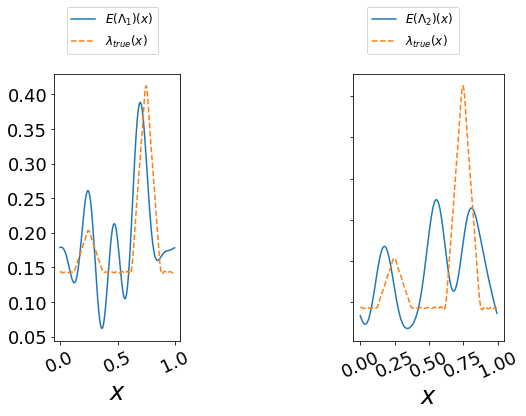

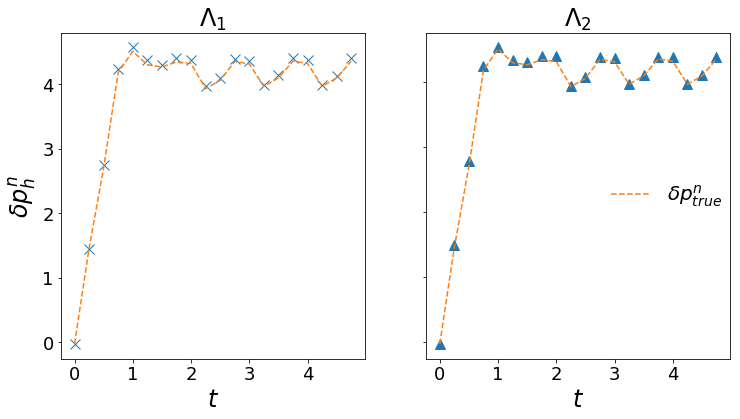

In [23]:
%run ~/UQ/examples/clustering.py

## finding optimal beta

```
[('PCN',
  {3: {'accepted': 2687, 'rejected': 7313}, 'beta': 0.10000000000000001}),
 ('PCN',
  {3: {'accepted': 1418, 'rejected': 8582}, 'beta': 0.20000000000000001}),
 ('PCN',
  {3: {'accepted': 892, 'rejected': 9108}, 'beta': 0.30000000000000004}),
 ('PCN',
  {3: {'accepted': 688, 'rejected': 9312}, 'beta': 0.40000000000000002}),
 ('PCN', {3: {'accepted': 492, 'rejected': 9508}, 'beta': 0.5}),
 ('PCN',
  {3: {'accepted': 404, 'rejected': 9596}, 'beta': 0.59999999999999998}),
 ('PCN',
  {3: {'accepted': 345, 'rejected': 9655}, 'beta': 0.70000000000000007}),
 ('PCN',
  {3: {'accepted': 304, 'rejected': 9696}, 'beta': 0.80000000000000004}),
 ('PCN',
  {3: {'accepted': 241, 'rejected': 9759}, 'beta': 0.90000000000000002}),
 ('PCN',
  {5: {'accepted': 2497, 'rejected': 7503}, 'beta': 0.10000000000000001}),
 ('PCN',
  {5: {'accepted': 1331, 'rejected': 8669}, 'beta': 0.20000000000000001}),
 ('PCN',
  {5: {'accepted': 842, 'rejected': 9158}, 'beta': 0.30000000000000004}),
 ('PCN',
  {5: {'accepted': 605, 'rejected': 9395}, 'beta': 0.40000000000000002}),
 ('PCN', {5: {'accepted': 457, 'rejected': 9543}, 'beta': 0.5}),
 ('PCN',
  {5: {'accepted': 357, 'rejected': 9643}, 'beta': 0.59999999999999998}),
 ('PCN',
  {5: {'accepted': 274, 'rejected': 9726}, 'beta': 0.70000000000000007}),
 ('PCN',
  {5: {'accepted': 271, 'rejected': 9729}, 'beta': 0.80000000000000004}),
 ('PCN',
  {5: {'accepted': 204, 'rejected': 9796}, 'beta': 0.90000000000000002})]
```